# Feature Subset Selection
In this example, we'll be using the optimizer `pyswarms.discrete.BinaryPSO` to perform feature subset selection to improve classifier performance. But before we jump right on to the coding, let's first explain some relevant concepts:

## A short primer on feature selection

The idea for feature subset selection is to be able to find the best features that are suitable to the classification task. We must understand that not all features are created equal, and some may be more relevant than others. Thus, if we're given an array of features, how can we know the most optimal subset? (yup, this is a rhetorical question!)

For a Binary PSO, the position of the particles are expressed in two terms: `1` or `0` (or on and off). If we have a particle $x$ on $d$-dimensions, then its position can be defined as:

$$x = [x_1, x_2, x_3, \dots, x_d] ~~~\text{where}~~~ x_i \in {0,1}$$

In this case, the position of the particle for each dimension can be seen as a simple matter of on and off. 

### Feature selection and the objective function

Now, suppose that we're given a dataset with $d$ features. What we'll do is that we're going to _assign each feature as a dimension of a particle_. Hence, once we've implemented Binary PSO and obtained the best position, we can then interpret the
binary array (as seen in the equation above) simply as turning a feature on and off. 

As an example, suppose we have a dataset with 5 features, and the final best position of the PSO is:

```python
>>> optimizer.best_pos
np.array([0, 1, 1, 1, 0])
>>> optimizer.best_cost
0.00
```

Then this means that the second, third, and fourth (or first, second, and third in zero-index) that are turned on are the selected features for the dataset. We can then train our classifier using only these features while dropping the others. How do we then define our objective function? (Yes, another rhetorical question!). We can design our own, but for now I'll be taking an equation from the works of [Vieira, Mendoca, Sousa, et al. (2013)](http://www.sciencedirect.com/science/article/pii/S1568494613001361).

$$f(X) = \alpha(1-P) + (1-\alpha) \left(1 - \dfrac{N_f}{N_t}\right)$$

Where $\alpha$ is a hyperparameter that decides the tradeoff between the classifier performance $P$, and the size of the feature subset $N_f$ with respect to the total number of features $N_t$. The classifier performance can be the accuracy, F-score, precision, and so on.

In [3]:
import sys
sys.path.append('../')
#code below used to deal with special characters on the file path during read_csv()
sys._enablelegacywindowsfsencoding() 

In [80]:
# Import modules
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt #MatPlotLib usado para desenhar o gráfico criado com o NetworkX

# Import PySwarms
import pyswarms as ps

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generating a toy dataset using scikit-learn
We'll be using `sklearn.datasets.make_classification` to generate a 100-sample, 15-dimensional dataset with three classes. We will then plot the distribution of the features in order to give us a qualitative assessment of the feature-space.

For our toy dataset, we will be rigging some parameters a bit. Out of the 10 features, we'll have only 5 that are informative, 5 that are redundant, and 2 that are repeated. Hopefully, we get to have Binary PSO select those that are informative, and prune those that are redundant or repeated.

In [125]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=500, n_features=20, n_classes=2, 
                           n_informative=5, n_redundant=0, n_repeated=0, 
                           random_state=None, shuffle=True)

#X, X_test, y, y_test = train_test_split(X, y, test_size=0.20, random_state=None)
#X, y = make_classification(n_samples=100, n_features=15, n_classes=3,
#                           n_informative=4, n_redundant=1, n_repeated=2,
#                           random_state=1)

In [133]:
#X.head()
#abc = df.reset_index().values.tolist()
X.shape

(452, 279)

In [132]:
datasetPath = "D:/USP/2018-1/Computação Bioinspirada/Trabalhos/Trabalho 2/PSO/datasets/arrhythmia.data"
df = pd.read_csv(datasetPath, sep=',', header=0, na_filter=True)#, header=None)
df = dataset_data.fillna(dataset_data.mean())

y = dataset_data.iloc[:,-1]
y = y.values
X = dataset_data.drop(labels='Class', axis=1)
X = X.values

'''
y = dataset_data.iloc[:,-1]
y = np.ravel(y)
X = dataset_data.drop(labels='Class', axis=1)
X = np.ravel(X)
'''

"\ny = dataset_data.iloc[:,-1]\ny = np.ravel(y)\nX = dataset_data.drop(labels='Class', axis=1)\nX = np.ravel(X)\n"

In [97]:
#y
#y = dataset_data.columns(len(dataset_data.columns)-1, axis=1)
aaa = pd.DataFrame(A)
bbb = pd.DataFrame(X)
aaa['labels'] = pd.Series(b)
bbb['labels'] = pd.Series(y)

In [134]:
df.shape

(452, 280)

In [89]:
# Plot toy dataset per feature
df = pd.DataFrame(X)
df['labels'] = pd.Series(y)

#sns.pairplot(df, hue='labels');

As we can see, there are some features that causes the two classes to overlap with one another. These might be features that are better off unselected. On the other hand, we can see some feature combinations where the two classes are shown to be clearly separated. These features can hopefully be retained and selected by the binary PSO algorithm.

We will then use a simple logistic regression technique using `sklearn.linear_model.LogisticRegression` to perform classification. A simple test of accuracy will be used to assess the performance of the classifier.

## Writing the custom-objective function
As seen above, we can write our objective function by simply taking the performance of the classifier (in this case, the accuracy), and the size of the feature subset divided by the total (that is, divided by 10), to return an error in the data. We'll now write our custom-objective function

In [135]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

# Create an instance of the classifier
classifier = linear_model.LogisticRegression()
#classifier = RandomForestClassifier(n_estimators = 64,
#                                    #max_features = 30,
#                                    bootstrap = True,
#                                    random_state = None)
    
#clf = forest
#clf.fit(X_trainOhFeatures, y_train)
#predictions = clf.predict(X_testOhFeatures)
#accuracy = accuracy_score(y_test, predictions)


# Define objective function
def f_per_particle(m, alpha):
    """Computes for the objective function per particle

    Inputs
    ------
    m : numpy.ndarray
        Binary mask that can be obtained from BinaryPSO, will
        be used to mask features.
    alpha: float (default is 0.5)
        Constant weight for trading-off classifier performance
        and number of features

    Returns
    -------
    numpy.ndarray
        Computed objective function
    """
    total_features = X.shape[1]
    # Get the subset of the features from the binary mask
    if np.count_nonzero(m) == 0: 
        #if the particle subset is only zeros, get the original set of attributes
        X_subset = X
    else:
        X_subset = X[:,m==1]
        
    #X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.20, random_state=None)
    # Perform classification and store performance in P
    #classifier.fit(X_train, y_train)
    #P = (classifier.predict(X_test) == y_test).mean()
    
    scores = cross_val_score(classifier, X_subset, y, cv=3)
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    P = scores.mean()
    particleScore.append(P)
    particleSize.append(X_subset.shape[1])
    # Compute for the objective function
    j = (alpha * (1.0 - P)
        + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    
    #j = (alpha * (1.0 - P)) + (1 - alpha) * (1 - (total_features - X_subset.shape[1]) / total_features)
    #print("Particle j: ", j)
    return j

In [188]:
def f(x, alpha=0.9):
    """Higher-level method to do classification in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    #print("f j: ", j)
    return np.array(j)

## Using Binary PSO
With everything set-up, we can now use Binary PSO to perform feature selection. For now, we'll be doing a global-best solution by setting the number of neighbors equal to the number of particles. The hyperparameters are also set arbitrarily. Moreso, we'll also be setting the distance metric as 2 (truth is, it's not really relevant because each particle will see one another).

Started at:  2018-05-24 03:25:21.312978


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few

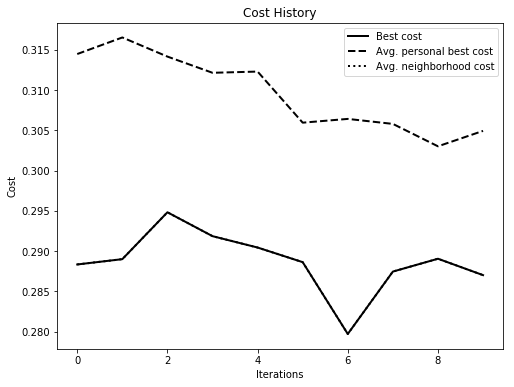

Finished at:  2018-05-24 03:29:02.970691
Total time spent:  0:03:41.657713


In [189]:
from datetime import datetime as dt
import time
from pyswarms.utils.environments import PlotEnvironment

start = dt.now()
print("Started at: ", str(start))
particleScore = list()
particleSize = list()
#mySubsets = list()

# Initialize swarm, arbitrary
options = {'c1': 2, 'c2': 2, 'w':0.3, 'k': 20, 'p':2}

# Call instance of PSO
dimensions = X.shape[1] # dimensions should be the number of features
#optimizer.reset()
#optimizer = ps.single.GlobalBestPSO(n_particles=1, dimensions=dimensions,
#                                    options=options)
optimizer = ps.discrete.BinaryPSO(n_particles=20, dimensions=dimensions, options=options)

# Perform optimization
#cost, pos = optimizer.optimize(f, print_step=1, iters=10, verbose=2)


# Initialize plot environment
plt_env = PlotEnvironment(optimizer, f, 10)

# Plot the cost
plt_env.plot_cost(figsize=(8,6));
plt.show()


#print(cost,pos)
end = dt.now()
print("Finished at: ", str(end))
total = end-start
print("Total time spent: ", total)

In [196]:
#http://pyswarms.readthedocs.io/en/latest/examples/visualization.html


In [191]:
print(optimizer.get_mean_pbest_history)
print(optimizer.personal_best_pos[5])

#mean_pbest_history

#optimizer.get_pos_history
#optimizer.get_velocity_history
#optimizer.pos_history #subsets of attributes [iters[particles]]


[0.31448533 0.31654327 0.31416821 0.31215416 0.31230486 0.30595629
 0.30642416 0.30580338 0.30301888 0.30493664]
[0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0
 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1
 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0
 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0
 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1]


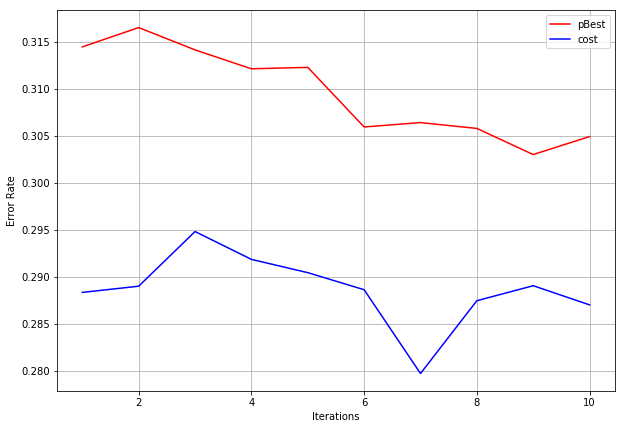

In [192]:

iterations = list(range(1,len(optimizer.get_cost_history)+1))
plt.figure(figsize=(10,7))
#plt.xlabel('2^i classes')
plt.xlabel('Iterations')
plt.ylabel('Error Rate')
#get_cost_history #erro médio da iteracao
#optimizer.mean_pbest_history #erro minimo pbest
plt.plot(iterations, optimizer.mean_pbest_history, 'r', label='pBest') 
plt.plot(iterations, optimizer.get_cost_history, 'b', label='cost') 
plt.legend()
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)


#plt.savefig("D:/USP/2018-1/Computação Bioinspirada/Trabalhos/iterationVSerrorRate2.png", format="PNG")


plt.show()

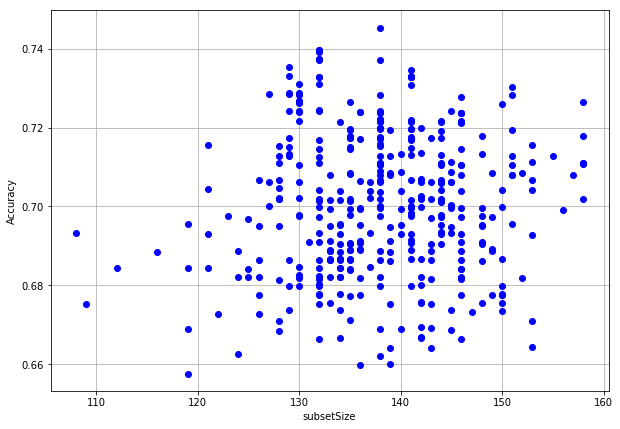

In [193]:
import matplotlib.pyplot as plt #MatPlotLib usado para desenhar o gráfico criado com o NetworkX

#iterations = list(range(1,len(optimizer.get_cost_history)+1))
plt.figure(figsize=(10,7))
#plt.xlabel('2^i classes')
plt.xlabel('subsetSize')
plt.ylabel('Accuracy')
plt.plot(particleSize, particleScore, 'bo')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True)


#plt.savefig("D:/USP/2018-1/Computação Bioinspirada/Trabalhos/iterationVSerrorRate2.png", format="PNG")


plt.show()

We can then train the classifier using the positions found by running another instance of logistic regression. We can compare the performance when we're using the full set of features

In [194]:
from sklearn.model_selection import cross_val_score
# Create two instances of LogisticRegression
#classfier = linear_model.LogisticRegression()
classifier = RandomForestClassifier(n_estimators = 64,
                                    #max_features = 30,
                                    bootstrap = True,
                                    random_state = None)

rank = list()

fullSet = cross_val_score(classifier, X, y, cv=5)
print("Full set Accuracy: %0.2f (+/- %0.2f)" % (fullSet.mean(), fullSet.std() * 2))
print("----------------------------------------------------------------------------")
bests = optimizer.personal_best_pos #optimizer.get_pos_history
for b in bests:
    # Get the selected features from the final positions
    X_selected_features = X[:,b==1]  # subset

    # Perform classification and store performance in P
    #classifier.fit(X_selected_features, y)
    scores = cross_val_score(classifier, X_selected_features, y, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), b)
    rank.append([scores.mean(), b])
    # Compute performance
    #subset_performance = (c1.predict(X_selected_features) == y).mean()
    #subset_performance = (classifier.predict(X_selected_features) == y).mean()
    

    #print('Subset performance: %.3f' % (subset_performance))

C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Full set Accuracy: 0.74 (+/- 0.07)
----------------------------------------------------------------------------


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.74 (+/- 0.08) [0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 1 1 1 1 1 0
 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0
 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1
 1 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0
 0 1 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1
 1 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1
 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 0 1
 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.74 (+/- 0.09) [1 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0
 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0
 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1
 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0
 1 1 1 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0
 1 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.74 (+/- 0.12) [1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1
 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1
 0 0 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0
 1 1 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0
 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1
 1 1 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.75 (+/- 0.11) [0 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1
 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 0 1 0 1
 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1
 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0
 0 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1
 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0
 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 0 1 1 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.73 (+/- 0.12) [1 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0
 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1
 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1
 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 1 0 0 1 1 0
 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0
 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0
 1 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.75 (+/- 0.09) [0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0
 1 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0
 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1
 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0
 0 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0
 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1
 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.72 (+/- 0.09) [0 0 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0
 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1
 1 1 1 1 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1
 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1
 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1
 0 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 1
 0 0 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.70 (+/- 0.07) [1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 1 1 0 1
 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0
 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0
 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0
 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1
 1 1 1 1 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1
 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0
 0 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.72 (+/- 0.10) [1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1
 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 1 0
 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1
 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 0
 0 1 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1
 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0
 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 1 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.71 (+/- 0.08) [0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1
 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0
 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 1 1 1 0 0 1
 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 1 0
 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1
 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1
 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 0 0 0 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.72 (+/- 0.09) [0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0
 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1
 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1
 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 0 1
 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0
 0 1 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 0
 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0
 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.74 (+/- 0.09) [0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 0 1 0
 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1
 1 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1
 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0
 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 0
 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0
 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 0 0 1 0
 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1 1 0 0 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.73 (+/- 0.08) [1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0
 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1
 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1
 0 1 1 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0
 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.72 (+/- 0.09) [0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0
 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 1
 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1
 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0
 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1
 1 0 1 1 0 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 1
 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 0
 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.73 (+/- 0.07) [1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0 1 1 0
 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0
 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0
 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1
 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1
 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1
 0 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.74 (+/- 0.10) [1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 0 1
 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1
 0 1 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1
 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1
 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 1 1 1
 0 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 1 0 0 1
 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 0 0
 1 1 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.72 (+/- 0.07) [1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1
 0 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1
 0 0 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 0
 1 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0
 1 0 1 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1
 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 0 1 1
 1 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1
 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.72 (+/- 0.09) [1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1
 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 0 0 1
 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0
 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1 0 1
 1 0 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0
 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.72 (+/- 0.10) [0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0
 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0
 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0
 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1
 0 0 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1
 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0
 1 1 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0
 0 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0]


C:\Users\Adriano\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.73 (+/- 0.10) [1 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 1
 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1
 0 1 0 1 1 0 0 1 0 1 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 1
 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1
 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1
 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0
 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1 0]


In [195]:
fullSetAccuracy = round(fullSet.mean(),4)
bestSubsetAccuracy = round(max(rank)[0],4)
bestSubsetLength = sum(max(rank)[1])

print("Full set accuracy:", fullSetAccuracy)
print("Best subset accuracy:", bestSubsetAccuracy)
print("Best subset length:", bestSubsetLength)
print("-----------------------------------------------")
print("-----------------------------------------------")
print("             length  |  accuracy")
print("full set     ", X.shape[1], "      ", fullSetAccuracy)
print("best subset  ", bestSubsetLength, "      ", bestSubsetAccuracy)

Full set accuracy: 0.7418
Best subset accuracy: 0.751
Best subset length: 132
-----------------------------------------------
-----------------------------------------------
             length  |  accuracy
full set      279        0.7418
best subset   132        0.751


# Ignore below

In [ ]:
# Create two instances of LogisticRegression
#classfier = linear_model.LogisticRegression()
classifier = RandomForestClassifier(n_estimators = 64,
                                    #max_features = 30,
                                    bootstrap = True,
                                    random_state = None)

scores = cross_val_score(classifier, X, y, cv=10)
print("Accuracy full set: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "len:",X.shape[1])

# Get the selected features from the final positions
X_selected_featuresPSO = X[:,pos==1]  # subset
X_selected_featuresReal = X[:,0:5] #real subset

# Perform classification and store performance in P
#classifier.fit(X_selected_features, y)
scoresReal = cross_val_score(classifier, X_selected_featuresReal, y, cv=10)
scoresPSO = cross_val_score(classifier, X_selected_featuresPSO, y, cv=10)

# Compute performance
#subset_performance = (c1.predict(X_selected_features) == y).mean()
#subset_performance = (classifier.predict(X_selected_features) == y).mean()

#print('Subset performance: %.3f' % (subset_performance))
print("Accuracy Real subset: %0.2f (+/- %0.2f)" % (scoresReal.mean(), scoresReal.std() * 2), "len:", X_selected_featuresReal.shape[1])
print("Accuracy PSO subset: %0.2f (+/- %0.2f)" % (scoresPSO.mean(), scoresPSO.std() * 2), "len:", X_selected_featuresPSO.shape[1])

In [ ]:
from sklearn.model_selection import cross_val_score
# Create two instances of LogisticRegression
#classfier = linear_model.LogisticRegression()
classifier = RandomForestClassifier(n_estimators = 64,
                                    #max_features = 30,
                                    bootstrap = True,
                                    random_state = None)

scores = cross_val_score(classifier, X, y, cv=5)
print("Full set Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("----------------------------------------------------------------------------")
bests = optimizer.personal_best_pos #optimizer.personal_best_pos
for best in bests:
    for b in best:
        # Get the selected features from the final positions
        X_selected_features = X[:,b==1]  # subset

        # Perform classification and store performance in P
        #classifier.fit(X_selected_features, y)
        scores = cross_val_score(classifier, X_selected_features, y, cv=5)

        # Compute performance
        #subset_performance = (c1.predict(X_selected_features) == y).mean()
        #subset_performance = (classifier.predict(X_selected_features) == y).mean()
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), b)

    #print('Subset performance: %.3f' % (subset_performance))

Another important advantage that we have is that we were able to reduce the features (or do dimensionality reduction) on our data. This can save us from the [curse of dimensionality](http://www.stat.ucla.edu/~sabatti/statarray/textr/node5.html), and may in fact speed up our classification.

Let's plot the feature subset that we have:

In [ ]:
# Plot toy dataset per feature
df1 = pd.DataFrame(X_selected_features)
df1['labels'] = pd.Series(y)

sns.pairplot(df1, hue='labels')